In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchvision
import torchvision.transforms.v2 as transforms
import os
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [4]:
import os

os.environ['KAGGLE_USERNAME'] = "Tazana"
os.environ['KAGGLE_KEY'] = "KGAT_ae7832557eae3064c9a913bae0131472"

!pip install -q kaggle

print("Descargando el dataset...")
!kaggle datasets download -d puneet6060/intel-image-classification

print("Descomprimiendo archivos...")
!mkdir -p kaggle
!unzip -q intel-image-classification.zip -d kaggle/

print("Archivos listos.")

Descargando el dataset...
Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 87% 300M/346M [00:02<00:00, 111MB/s] 
100% 346M/346M [00:02<00:00, 147MB/s]
Descomprimiendo archivos...
Archivos listos.


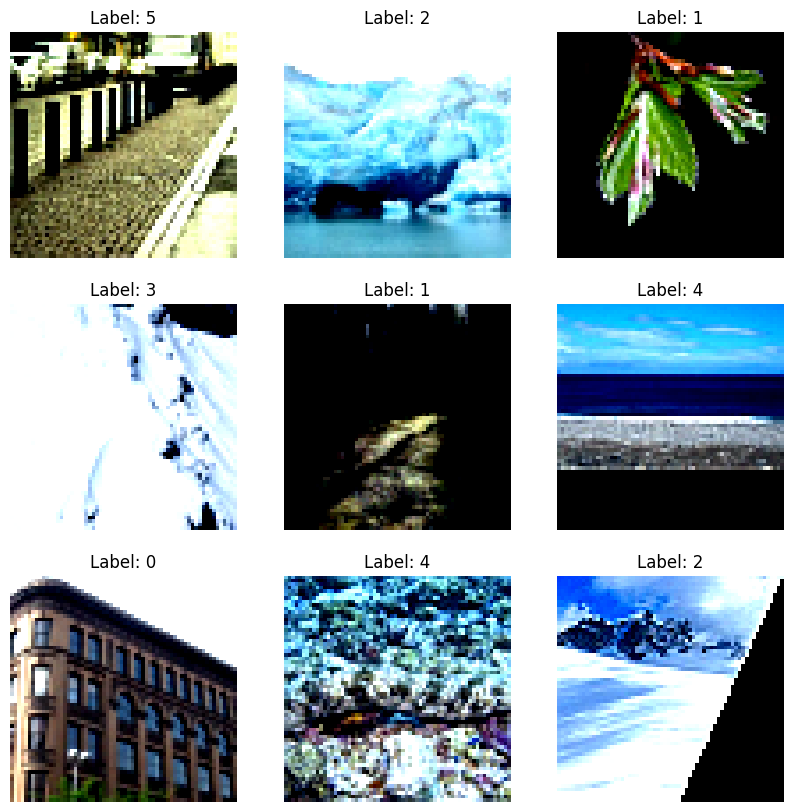

In [17]:
batch_size = 128
images_size = (64, 64)
epochs = 50
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformaciones
train_transform = transforms.Compose([
    transforms.Resize(images_size),
    transforms.TrivialAugmentWide(),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=mean, std=std)
])

test_transform = transforms.Compose([
    transforms.Resize(images_size),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=mean, std=std)
])

# Cargar datasets
train_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_train/seg_train',
    transform=train_transform
)

test_dataset = torchvision.datasets.ImageFolder(
    root='kaggle/seg_test/seg_test',
    transform=test_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

# Ver ejemplos
for images, labels in train_loader:
    images = images * 0.5 + 0.5
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img_to_show = images[i].permute(1, 2, 0)

        plt.imshow(img_to_show)
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

In [19]:
# Crear modelo
input_size = 3 * images_size[0] * images_size[1]
n_classes = len(train_dataset.classes)

model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(input_size, 4096),
    nn.BatchNorm1d(4096),
    nn.GELU(),
    nn.Dropout(0.4),

    nn.Linear(4096, 1024),
    nn.BatchNorm1d(1024),
    nn.GELU(),
    nn.Dropout(0.3),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.GELU(),
    nn.Dropout(0.2),

    nn.Linear(512, n_classes)
)

model = model.to(device)
if hasattr(torch, 'compile'):
    try:
        model = torch.compile(model)
        print("Model compilation (torch.compile) exitosa.")
    except:
        print("torch.compile no soportado, continuando normal.")

print(model)
print(f"\nParámetros: {sum(p.numel() for p in model.parameters()):,}")

Model compilation (torch.compile) exitosa.
OptimizedModule(
  (_orig_mod): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=4096, bias=True)
    (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): GELU(approximate='none')
    (4): Dropout(p=0.4, inplace=False)
    (5): Linear(in_features=4096, out_features=1024, bias=True)
    (6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=1024, out_features=512, bias=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): GELU(approximate='none')
    (12): Dropout(p=0.2, inplace=False)
    (13): Linear(in_features=512, out_features=6, bias=True)
  )
)

Parámetros: 55,070,214


In [20]:
# Loss y optimizer
loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [21]:
def train():
    model.train()
    total_loss, correct, total = 0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)

        output = model(x)
        batch_loss = loss_function(output, y)

        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        correct += (output.argmax(1) == y).sum().item()
        total += y.size(0)

    epoch_loss = total_loss / len(train_loader)
    epoch_acc = correct / total

    print(f'Train - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [22]:
def validate():
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)

            output = model(x)
            batch_loss = loss_function(output, y)

            total_loss += batch_loss.item()
            correct += (output.argmax(1) == y).sum().item()
            total += y.size(0)

    epoch_loss = total_loss / len(test_loader)
    epoch_acc = correct / total

    print(f'Valid - Loss: {epoch_loss:.4f} Accuracy: {epoch_acc:.4f}')
    return epoch_loss, epoch_acc

In [23]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_loss = float('inf')
path_checkpoint = 'checkpoint.pth'
start_epoch = 0

# if os.path.exists(path_checkpoint):
#     print(f"Cargando checkpoint: {path_checkpoint}...")
#     checkpoint = torch.load(path_checkpoint, map_location=device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     best_val_loss = checkpoint['val_loss']
#     print(f"Checkpoint cargado. Mejor Loss: {best_val_loss:.4f}")

for epoch in range(start_epoch, epochs):
    print(f'Epoch: {epoch}')
    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    scheduler.step()
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }
        torch.save(checkpoint, path_checkpoint)
        print(f"Mejor modelo guardado (Loss: {val_loss:.4f}) en epoca {epoch}")

Epoch: 0
Train - Loss: 1.5627 Accuracy: 0.4015
Valid - Loss: 1.3390 Accuracy: 0.5327
Mejor modelo guardado (Loss: 1.3390) en epoca 0
Epoch: 1
Train - Loss: 1.4520 Accuracy: 0.4675
Valid - Loss: 1.2802 Accuracy: 0.5780
Mejor modelo guardado (Loss: 1.2802) en epoca 1
Epoch: 2
Train - Loss: 1.4109 Accuracy: 0.4911
Valid - Loss: 1.2429 Accuracy: 0.5800
Mejor modelo guardado (Loss: 1.2429) en epoca 2
Epoch: 3
Train - Loss: 1.3906 Accuracy: 0.5051
Valid - Loss: 1.2159 Accuracy: 0.5983
Mejor modelo guardado (Loss: 1.2159) en epoca 3
Epoch: 4
Train - Loss: 1.3696 Accuracy: 0.5139
Valid - Loss: 1.2185 Accuracy: 0.5970
Epoch: 5
Train - Loss: 1.3474 Accuracy: 0.5242
Valid - Loss: 1.2162 Accuracy: 0.5983
Epoch: 6
Train - Loss: 1.3345 Accuracy: 0.5336
Valid - Loss: 1.2145 Accuracy: 0.6073
Mejor modelo guardado (Loss: 1.2145) en epoca 6
Epoch: 7
Train - Loss: 1.3165 Accuracy: 0.5411
Valid - Loss: 1.1735 Accuracy: 0.6250
Mejor modelo guardado (Loss: 1.1735) en epoca 7
Epoch: 8
Train - Loss: 1.3089 Ac

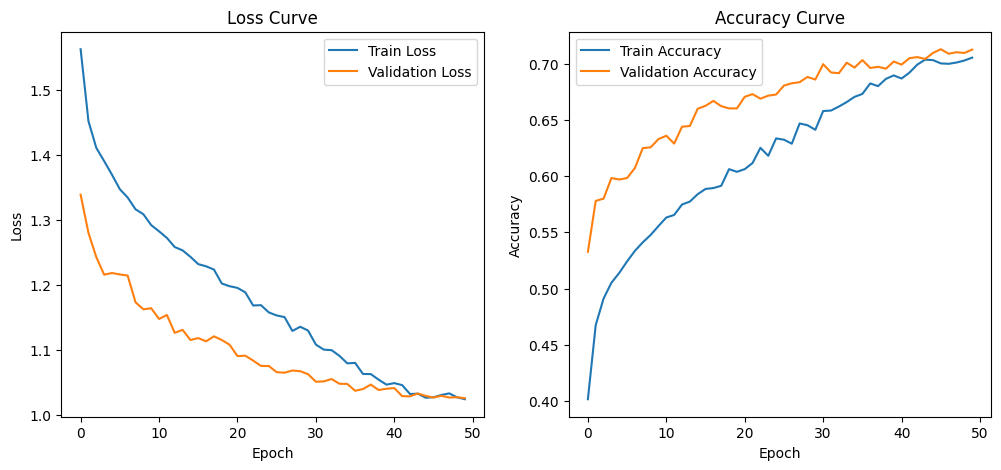

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()